<a href="https://colab.research.google.com/github/kazemihabib/nlp_assignment_1/blob/LSTM/assignment1_2425.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1
**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: Sexism Detection, Multi-class Classification, RNNs, Transformers, Huggingface



# Contact
For any doubt, question, issue or help, you can always contact us at the following email addresses:

Teaching Assistants:

- Federico Ruggeri -> federico.ruggeri6@unibo.it
- Eleonora Mancini -> e.mancini@unibo.it

Professor:
- Paolo Torroni -> p.torroni@unibo.it

# Introduction
You are asked to address the [EXIST 2023 Task 1](https://clef2023.clef-initiative.eu/index.php?page=Pages/labs.html#EXIST) on sexism detection.

## Problem Definition
The systems have to decide whether or not a given tweet contains or describes sexist expressions or behaviors (i.e., it is sexist itself, describes a sexist situation or criticizes a sexist behavior).

### Examples:

**Text**: *Can’t go a day without women womening*

**Label**: Sexist

**Text**: *''Society's set norms! Happy men's day though!#weareequal''*

**Label**: Not sexist

In [41]:
from google.colab import drive
import os
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
import zipfile
import os

PATH_IN_G_DRIVE="/content/drive/MyDrive/Projects/NLP/1"

# If glove embeddings have not been downloaded already, download them to GDrive.
download_path = os.path.join(PATH_IN_G_DRIVE, "glove.6B.zip")

# Check if the file already exists
if not os.path.exists(download_path):
  # Download the GloVe embeddings
  !wget https://nlp.stanford.edu/data/wordvecs/glove.6B.zip -O "$download_path"
else:
  print("File already exists at:", download_path)


# Copy the files in GDrive to my colab local
!cp -r "$PATH_IN_G_DRIVE"/* /content/


########## Unzip embeddings ###############

zip_file_path = "/content/glove.6B.zip"

extract_path = "/content/glove.6B"


if os.path.exists(zip_file_path):
    try:
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print(f"Successfully extracted files from '{zip_file_path}' to '{extract_path}'")
    except zipfile.BadZipFile:
        print(f"Error: '{zip_file_path}' is not a valid zip file.")
else:
    print(f"Error: '{zip_file_path}' not found.")

File already exists at: /content/drive/MyDrive/Projects/NLP/1/glove.6B.zip
Successfully extracted files from '/content/glove.6B.zip' to '/content/glove.6B'


#[Task 1 - 1.0 points] Corpus

We have preparared a small version of EXIST dataset in our dedicated [Github repository](https://github.com/lt-nlp-lab-unibo/nlp-course-material/tree/main/2024-2025/Assignment%201/data).

Check the `A1/data` folder. It contains 3 `.json` files representing `training`, `validation` and `test` sets.

The three sets are slightly unbalanced, with a bias toward the `Non-sexist` class.



### Dataset Description
- The dataset contains tweets in both English and Spanish.
- There are labels for multiple tasks, but we are focusing on **Task 1**.
- For Task 1, soft labels are assigned by six annotators.
- The labels for Task 1 represent whether the tweet is sexist ("YES") or not ("NO").







### Example


    "203260": {
        "id_EXIST": "203260",
        "lang": "en",
        "tweet": "ik when mandy says “you look like a whore” i look cute as FUCK",
        "number_annotators": 6,
        "annotators": ["Annotator_473", "Annotator_474", "Annotator_475", "Annotator_476", "Annotator_477", "Annotator_27"],
        "gender_annotators": ["F", "F", "M", "M", "M", "F"],
        "age_annotators": ["18-22", "23-45", "18-22", "23-45", "46+", "46+"],
        "labels_task1": ["YES", "YES", "YES", "NO", "YES", "YES"],
        "labels_task2": ["DIRECT", "DIRECT", "REPORTED", "-", "JUDGEMENTAL", "REPORTED"],
        "labels_task3": [
          ["STEREOTYPING-DOMINANCE"],
          ["OBJECTIFICATION"],
          ["SEXUAL-VIOLENCE"],
          ["-"],
          ["STEREOTYPING-DOMINANCE", "OBJECTIFICATION"],
          ["OBJECTIFICATION"]
        ],
        "split": "TRAIN_EN"
      }
    }

### Instructions
1. **Download** the `A1/data` folder.
2. **Load** the three JSON files and encode them as pandas dataframes.
3. **Generate hard labels** for Task 1 using majority voting and store them in a new dataframe column called `hard_label_task1`. Items without a clear majority will be removed from the dataset.
4. **Filter the DataFrame** to keep only rows where the `lang` column is `'en'`.
5. **Remove unwanted columns**: Keep only `id_EXIST`, `lang`, `tweet`, and `hard_label_task1`.
6. **Encode the `hard_label_task1` column**: Use 1 to represent "YES" and 0 to represent "NO".

In [43]:
!pip install autocorrect
!pip install optuna

In [1]:
import pandas as pd
import json
from collections import Counter
import string
import re
import numpy as np
import spacy
# from spellchecker import SpellChecker
from autocorrect import Speller
from pathlib import Path
import os
import optuna
from torch.utils.tensorboard import SummaryWriter

# Also install the following packages
# pip install pyarrow
# pip install torch
# pip install scikit-learn



/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from IPython.core.magic import register_cell_magic

# Custom magic command to skip the cell
@register_cell_magic
def skip(line, cell):
    return


In [3]:
def mojority_of_votes(votes:list):
    """ given an array of votes, return the mode or None if there is no mode """
    count = Counter(votes)
    most_common = count.most_common(2)
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return None
    if most_common:
        return most_common[0][0]

In [4]:
def preprocess(data:pd.DataFrame):
    # method for all the preprocessing steps
    data = data.T # make the attributes as columns and data points as rows
    data['hard_label_task1'] = data['labels_task1'].apply(mojority_of_votes) #generate hard labels
    data = data[data['hard_label_task1'].notna()] # drop rows without a majority label
    data = data[data['lang'] == 'en'] # drop rows where lang is not 'en'
    data = data[['id_EXIST', 'lang', 'tweet', 'hard_label_task1']] # keeping only necessary columns
    data['hard_label_task1'] = data['hard_label_task1'].map({'YES': 1, 'NO': 0}) # encoding 'hard_label_task1' column
    return data

In [5]:
data_training = pd.read_json(Path('data', 'training.json'))
data_test = pd.read_json(Path('data', 'test.json'))
data_validation = pd.read_json(Path('data', 'validation.json'))

data_training = preprocess(data_training)
data_test = preprocess(data_test)
data_validation = preprocess(data_validation)

data_training.head()


,id_EXIST,lang,tweet,hard_label_task1
200002,200002,en,Writing a uni essay in my local pub with a cof...,1
200003,200003,en,@UniversalORL it is 2021 not 1921. I dont appr...,1
200006,200006,en,According to a customer I have plenty of time ...,1
200007,200007,en,"So only 'blokes' drink beer? Sorry, but if you...",1
200008,200008,en,New to the shelves this week - looking forward...,0


# [Task2 - 0.5 points] Data Cleaning
In the context of tweets, we have noisy and informal data that often includes unnecessary elements like emojis, hashtags, mentions, and URLs. These elements may interfere with the text analysis.



### Instructions
- **Remove emojis** from the tweets.
- **Remove hashtags** (e.g., `#example`).
- **Remove mentions** such as `@user`.
- **Remove URLs** from the tweets.
- **Remove special characters and symbols**.
- **Remove specific quote characters** (e.g., curly quotes).
- **Perform lemmatization** to reduce words to their base form.

In [7]:
!python -m spacy download en

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 2.5 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [8]:
# spaCy English model
nlp = spacy.load('en_core_web_sm')
spell = Speller()

In [10]:

def remove_emojis(text):
    # removing emojis with regex, including
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           u"\U0001F914"  # 🤔
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_hashtags(text):
    return re.sub(r'#\w+', '', text)

def remove_mentions(text):
    return re.sub(r'@\w+', '', text)

def remove_urls(text):
    return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

def remove_special_characters(text):
    return text.translate(str.maketrans('', '', string.punctuation))

def remove_quotes(text):
    return text.replace('“', '').replace('”', '').replace('‘', '').replace('’', '')

def lemmatize_text(text):
    # performing lemmatization using spacy
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

# =================== Additional preprocessing techniques =================================
# important to reduce the number of unseen vobabs as Glove contains mostly lowercase tokens
def lowercase_text(text):
    return text.lower()  # convert all text to lowercase

def correct_typos(text):
    return spell(text)

def clean_text(tweet):
    tweet = remove_emojis(tweet)
    tweet = remove_hashtags(tweet)
    tweet = remove_mentions(tweet)
    tweet = remove_urls(tweet)
    tweet = remove_special_characters(tweet)
    tweet = remove_quotes(tweet)
    tweet = lowercase_text(tweet)
    tweet = correct_typos(tweet)
    tweet = lemmatize_text(tweet)
    tweet = tweet.strip()
    return tweet


In [11]:
# testing if all is fine
sample_text = "this is awsome bro! 😁 @johnsmith #wait www.google.com"
clean_text(sample_text)

'this be awesome bro'

In [12]:
%%skip
# If you want to clean the entire dataset, instead of loading the cleaned dataset,
# comment the skip magic command and run the cell
def clean_dataset_tweets(data:pd.DataFrame):
    data['tweet'] = data['tweet'].apply(clean_text)
    return data

data_training_cleaned = clean_dataset_tweets(data_training)
data_test_cleaned = clean_dataset_tweets(data_test)
data_validation_cleaned = clean_dataset_tweets(data_validation)

data_training_cleaned.head()

In [6]:
stored_data_dir = "stored_data"

# Define file paths
training_path = os.path.join(stored_data_dir, 'data_training_cleaned.parquet')
test_path = os.path.join(stored_data_dir, 'data_test_cleaned.parquet')
validation_path = os.path.join(stored_data_dir, 'data_validation_cleaned.parquet')

In [55]:
%%skip
# If you want to save the cleaned dataset, comment the skip magic command
# and run the cell

if not os.path.exists(stored_data_dir):
    os.makedirs(stored_data_dir)

# Save the cleaned datasets to Parquet
data_training_cleaned.to_parquet(training_path, index=False)
data_test_cleaned.to_parquet(test_path, index=False)
data_validation_cleaned.to_parquet(validation_path, index=False)

In [7]:
# Load the saved cleaned datasets from disk
data_training_cleaned = pd.read_parquet(training_path)
data_test_cleaned = pd.read_parquet(test_path)
data_validation_cleaned = pd.read_parquet(validation_path)

# [Task 3 - 0.5 points] Text Encoding
To train a neural sexism classifier, you first need to encode text into numerical format.




### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.





### Note : What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe **must** be added to the vocabulary.
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **special token** (e.g., [UNK]) and a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)



### More about OOV

For a given token:

* **If in train set**: add to vocabulary and assign an embedding (use GloVe if token in GloVe, custom embedding otherwise).
* **If in val/test set**: assign special token if not in vocabulary and assign custom embedding.

Your vocabulary **should**:

* Contain all tokens in train set; or
* Union of tokens in train set and in GloVe $\rightarrow$ we make use of existing knowledge!

## Embedding Strategy

For this project, this pretrained word vector is used:

`Wikipedia 2014 + Gigaword 5 (6B tokens, 400K vocab, uncased, 300d vectors, 822 MB download)`

which can be downlaoded from https://github.com/stanfordnlp/GloVe?tab=readme-ov-file

In [57]:
def load_glove_embeddings(glove_file_path, embedding_dim):
    embeddings_index = {}
    with open(glove_file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:embedding_dim+1], dtype='float32')
            embeddings_index[word] = coefs
    return embeddings_index

# Example usage
glove_file_path = Path('glove.6B', 'glove.6B.50d.txt') #we choose the XYZ dim
embedding_dim = 50  # You can choose any dimension

glove_embeddings = load_glove_embeddings(glove_file_path, embedding_dim)

In [58]:
UNKNOWN_TOKEN = "[UNK]"
PADDING_TOKEN = "[PAD]"
def create_vocabulary_and_embeddings(train_tokens, glove_embeddings, embedding_dim):
    vocab = {} #to store the training set tokens and their indices
    embedding_matrix = [] #to store all the embedding vectors of our vocabulary
    new_tokens = 0 # count how many words from the training are not in the glove embedding
    new_tokens_list = []

    # Dealing with the padding token and assigning zero embedding to it
    special_pad_embedding = np.zeros(embedding_dim)  # Zero embedding for padding
    vocab[PADDING_TOKEN] = 0
    embedding_matrix.append(special_pad_embedding)

    # dealing with the unknown token and assigning a random embedding to it
    special_embedding = np.random.rand(embedding_dim)
    vocab[UNKNOWN_TOKEN] = 1
    embedding_matrix.append(special_embedding)



    for token in train_tokens:
        if token not in vocab:
            if token in glove_embeddings:
                vocab[token] = len(vocab)
                embedding_matrix.append(glove_embeddings[token])
            else:
                # if a token is not the glove_embedding we add it to the vocab and create a
                # random embedding vector for it
                vocab[token] = len(vocab)
                custom_embedding = np.random.rand(embedding_dim)
                embedding_matrix.append(custom_embedding)
                new_tokens += 1
                new_tokens_list.append(token)

    embedding_matrix = np.array(embedding_matrix, dtype='float32')
    print(f"{new_tokens} tokens from the training set not present in the glove embeddings.")

    return vocab, embedding_matrix, new_tokens_list

train_tokens = ['example', 'tokens', 'from', 'train', 'set', 'from']
vocab, embedding_matrix, _ = create_vocabulary_and_embeddings(train_tokens, glove_embeddings, embedding_dim)

0 tokens from the training set not present in the glove embeddings.


In [59]:
training_tweets = data_training_cleaned['tweet'].tolist()
training_tweets = ' '.join(training_tweets)
words_list = training_tweets.split()
print(f"the tweets contain a total of {len(words_list)} words.\nFirst 50 words: {words_list[:50]}")

the tweets contain a total of 76446 words.
First 50 words: ['write', 'a', 'uni', 'essay', 'in', 'my', 'local', 'pub', 'with', 'a', 'coffee', 'random', 'old', 'man', 'keep', 'ask', 'I', 'drunk', 'question', 'when', 'I', 'm', 'try', 'to', 'concentrate', 'amp', 'end', 'with', 'good', 'luck', 'but', 'you', 'just', 'end', 'up', 'get', 'married', 'and', 'not', 'use', 'it', 'anyway', 'be', 'alive', 'and', 'well', 'it', 'be', '2021', 'not']


In [60]:
vocab, embedding_matrix, unknown_words = create_vocabulary_and_embeddings(words_list, glove_embeddings, embedding_dim)
print(f"total vocabulary size: {len(vocab)}\nembedding_matrix shape: {embedding_matrix.shape}")

1224 tokens from the training set not present in the glove embeddings.
total vocabulary size: 8602
embedding_matrix shape: (8602, 50)


In [61]:
print("some examples of unknown tokens in the tweets that are not present in the glove embedding: ")
print(', '.join(unknown_words[:100]))

some examples of unknown tokens in the tweets that are not present in the glove embedding: 
I, earlyinlife, godcolette, anywheregood, voyeuristically, comic_strip, gamergate, breadtube, releasethu, comicsgate, shitstorm, peachfuzz, futanari, 2014i, theythis, angeryou, bitchesid, downvote, 30somethe, allegationsjudge, mramgtowincel, womanhating, angriesbecause, catastrophizing, outbigg, redpill, blackpilado, ironicamente, earlierwhy, notallman, 🤣, vaginanot, notallmen, laylamoran, soulsmixed, thisthat, retweetsnintendo, switchsportsnotallmenwow, decentish, ndor, consentjust, transwoman, heathensno, family27, transphobe, violencesthey, discourseinto, weeksboth, nosetonose, allyship, harrisharb, catcall, itsnotacomplimentmelbournecom, pedophiliajust, weekshow, code5kp5qw1, societyeducation, djín, nonethelesscome, slimzosrecording, normshappy, makhulu, ahhhhhh, don´t, ¨some, marriage¨, productsinclude, internet‍‍, shivaami, onlineregister, 2022time, placewoman, nollaigh, 🧋, womensday, 2021

## Preprocessing Strategy for Cleaning the Text
for the preprocessing (text cleaning) strategy with propose two additional methods to decrease the number of tweet tokens that are not present in the Glove Embedding. This means we assign less random embeddings and the token embeddings become more meaningful overal.

1. `lowercase_text`: most of the Glove tokens are lowercase. So we lowercase all tokens.
2. `correct_typos`: tweets contain many typos. By correcting the typos we can find the correct token embeddings of a faulty word. This requires more preprocessing time as we need to check all the tokens. By it pays off well in the end.

![image.png](https://github.com/kazemihabib/nlp_assignment_1/blob/LSTM/preprocessing_strategies.png?raw=1)

## How to use the embedding:

In [62]:
def get_text_embedding_matrix(text, vocab, embedding_matrix):
    # given a text, return the matrix of its embeddings
    tokens = text.split()
    text_embeddings = np.zeros((len(tokens), embedding_matrix.shape[1]), dtype='float32')
    for i, token in enumerate(tokens):
        token_index = vocab.get(token, vocab["[UNK]"]) #get index of token if present in vocab, otherwise [UNK]
        text_embeddings[i] = embedding_matrix[token_index]

    return text_embeddings

In [63]:
example_text = "example text to embed"
embedding_matrix_for_text = get_text_embedding_matrix(example_text, vocab, embedding_matrix)
print(f"embed matrix with a shape {embedding_matrix_for_text.shape}")

embed matrix with a shape (4, 50)


# [Task 4 - 1.0 points] Model definition

You are now tasked to define your sexism classifier.




### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.

### Token to embedding mapping

You can follow two approaches for encoding tokens in your classifier.

### Work directly with embeddings

- Compute the embedding of each input token
- Feed the mini-batches of shape (batch_size, # tokens, embedding_dim) to your model

### Work with Embedding layer

- Encode input tokens to token ids
- Define a Embedding layer as the first layer of your model
- Compute the embedding matrix of all known tokens (i.e., tokens in your vocabulary)
- Initialize the Embedding layer with the computed embedding matrix
- You are **free** to set the Embedding layer trainable or not

### Padding

Pay attention to padding tokens!

Your model **should not** be penalized on those tokens.

#### How to?

There are two main ways.

However, their implementation depends on the neural library you are using.

- Embedding layer
- Custom loss to compute average cross-entropy on non-padding tokens only

**Note**: This is a **recommendation**, but we **do not penalize** for missing workarounds.

In [64]:
import matplotlib.pyplot as plt

def plot_training_validation_loss(train_losses, val_losses):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
    plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_training_validation_f1(train_f1s, val_f1s):
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_f1s) + 1), train_f1s, label='Train F1')
    plt.plot(range(1, len(val_f1s) + 1), val_f1s, label='Validation F1')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.title('Training and Validation F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils

class BaselineModel(nn.Module):
    """
    Baseline Model: A Bidirectional LSTM with a Dense layer on top.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, pad_idx, dropout, ):
        super(BaselineModel, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(self.dropout(hidden))
        return torch.sigmoid(output)


In [66]:
class Model_1(nn.Module):
    """
    Model 1: Manually Add an additional LSTM layer to the Baseline model.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim_1,
                 hidden_dim_2, output_dim, pad_idx, dropout_rate_1):
        super(Model_1, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm1 = nn.LSTM(
            embedding_dim,
            hidden_dim_1,
            bidirectional=True,
            batch_first=True
        )

        self.lstm_dropout = nn.Dropout(dropout_rate_1)

        self.lstm2 = nn.LSTM(
            hidden_dim_1 * 2,
            hidden_dim_2,
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim_2 * 2, output_dim)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, _ = self.lstm1(packed_embedded)
        unpacked_output, lengths = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        unpacked_output = self.lstm_dropout(unpacked_output)
        packed_output = rnn_utils.pack_padded_sequence(unpacked_output, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm2(packed_output)
        unpacked_output, lengths = rnn_utils.pad_packed_sequence(packed_output, batch_first=True)
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(hidden)

        return torch.sigmoid(output)


In [67]:
import torch
import torch.nn as nn
import torch.nn.utils.rnn as rnn_utils

class M2(nn.Module):
    """
    Model 2: Adds an additional LSTM layer to the Baseline model. Instead of implementing manually,
    num_layer=2 been used and the hidden dim of two LSTM layers are same.
    """
    def __init__(self, vocab_size, embedding_dim, embedding_matrix, hidden_dim, output_dim, pad_idx, dropout):
        super(M2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_matrix, dtype=torch.float32),
            freeze=True,  # Pre-trained embeddings, not trainable
            padding_idx=pad_idx
        )
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=2,  # 2 LSTM layers
            bidirectional=True,
            batch_first=True,
            dropout=dropout  # Add dropout between LSTM layers
        )
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text, lengths):
        embedded = self.embedding(text)
        packed_embedded = rnn_utils.pack_padded_sequence(embedded, lengths, batch_first=True, enforce_sorted=False)
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        # Extract the last hidden state from both layers (forward and backward)
        # Concatenate the last forward and backward hidden states of the top LSTM layer
        hidden = torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        output = self.fc(hidden)

        return torch.sigmoid(output)


In [68]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
def train(model, iterator, optimizer, criterion, device, epoch):
    """
    Train the model for one epoch
    """

    model.train()
    epoch_loss = 0
    all_preds = []
    all_labels = []

    for batch_idx, (padded_sequences, lengths, labels) in enumerate(iterator):

        padded_sequences = padded_sequences.to(device)
        lengths = lengths
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(padded_sequences, lengths).squeeze(1)

        loss = criterion(predictions, labels.float())
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

        preds = (predictions >= 0.5).long()  # Predictions for this batch
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    # Calculate accuracy and F1 for the epoch
    train_accuracy = accuracy_score(all_labels, all_preds)
    train_f1 = f1_score(all_labels, all_preds, average="macro", zero_division=1.0)

    return epoch_loss / len(iterator), train_accuracy, train_f1

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


def evaluate(model, iterator, criterion, device):
    """
    Evaluate the model on the given validation set
    """
    model.eval()
    epoch_loss = 0
    prediction_scores = []
    binary_predictions = []
    true_labels = []

    with torch.no_grad():
        for padded_sequences, lengths, labels in iterator:
            padded_sequences = padded_sequences.to(device)
            lengths = lengths
            labels = labels.to(device)

            predictions = model(padded_sequences, lengths).squeeze(1)
            loss = criterion(predictions, labels)

            epoch_loss += loss.item()
            preds = (predictions >= 0.5).long()
            prediction_scores.extend(predictions.cpu().numpy())
            binary_predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, binary_predictions)
    f1 = f1_score(true_labels, binary_predictions, average="macro", zero_division=1.0)

    return epoch_loss / len(iterator), accuracy, f1, prediction_scores

In [70]:
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim

def train_and_evaluate(model, model_name, train_loader, val_loader, vocab, embedding_matrix,
                         device, num_epochs, lr, weight_decay,
                         early_stopping_patience, save_model_path):
  """
  Train the model for the specified number of epochs, utilizing early stopping to save the best-performing model. Evaluate the best model on the validation set and return the corresponding validation metrics.
  """
  model_metrics = {
    'val_loss': [],
    'val_accuracy': [],
    'val_f1': [],
    'val_prediction_scores': [],
  }


  optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
  criterion = nn.BCELoss()

  best_val_f1 = float(0)
  early_stopping_counter = 0
  model_metrics_indx = 0
  for epoch in range(num_epochs):
      train_loss, train_accuracy, train_f1 = train(model, train_loader, optimizer, criterion, device, epoch)

      val_loss, val_accuracy, val_f1, val_prediction_scores = evaluate(model, val_loader, criterion, device)

      print(f"{model_name}: Epoch {epoch+1}/{num_epochs}")
      print(f"{model_name}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, train_f1: {train_f1:.4f}")
      print(f"{model_name}: Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}, Validation F1-Score: {val_f1:.4f}")

      if val_f1 > best_val_f1:
          best_val_f1 = val_f1
          model_metrics_indx = epoch
          early_stopping_counter = 0
          torch.save(model.state_dict(), save_model_path)

          model_metrics['val_loss'] = val_loss
          model_metrics['val_accuracy'] = val_accuracy
          model_metrics['val_f1'] = val_f1
          model_metrics['val_prediction_scores'] = val_prediction_scores
      else:
          early_stopping_counter += 1
          print(f"{model_name}: No improvement for {early_stopping_counter} epoch(s).")

      if early_stopping_counter >= early_stopping_patience:
          print(f"{model_name}: Early stopping triggered. Training stopped.")
          break


  model.load_state_dict(torch.load(save_model_path, weights_only=True))  # Load the saved state dictionary

  return model, model_metrics

In [71]:
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch

class TweetDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenize text into indices based on vocab
        token_ids = [self.vocab.get(token, self.vocab[UNKNOWN_TOKEN]) for token in text.split()]
        return torch.tensor(token_ids), torch.tensor(label, dtype=torch.float)

# Collate function to pad sequences dynamically
def collate_fn(batch):
    texts, labels = zip(*batch)
    padded_texts = pad_sequence(texts, batch_first=True, padding_value=vocab[PADDING_TOKEN])
    lengths = torch.tensor([len(seq) for seq in texts])
    labels = torch.tensor(labels, dtype=torch.float)

    return padded_texts, lengths, labels

train_dataset = TweetDataset(
    texts=data_training_cleaned['tweet'].tolist(),
    labels=data_training_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)

val_dataset = TweetDataset(
    texts=data_validation_cleaned['tweet'].tolist(),
    labels=data_validation_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)

test_dataset = TweetDataset(
    texts=data_test_cleaned['tweet'].tolist(),
    labels=data_test_cleaned['hard_label_task1'].tolist(),
    vocab=vocab
)


# Hyperparameter optimization
We utilized the Optuna library to systematically search for the optimal hyperparameter configuration for our models. This process yielded the following parameters:

In [72]:

bl_best_params = {"hidden_dim": 87, "dropout": 0.23805379126106954, "learning_rate": 0.009113727618687178, "weight_decay": 0.0019464188645384136}


In [73]:
m1_best_params = {'hidden_dim_1': 77, 'hidden_dim_2': 159, 'dropout_rate_1': 0.2671372067937484, 'learning_rate': 0.0058643763991166565, 'weight_decay': 0.002899357808030349}

In [74]:
m2_best_params = {'hidden_dim': 86, 'dropout': 0.5118279706204433, 'learning_rate': 0.005014704657881483, 'weight_decay': 0.002717923092381837}

\# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline and Model 1.



### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.
* Evaluate your models using macro F1-score.

In [75]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

def plot_precision_recall_curve(model_name, true_labels, predictions):
    precision, recall, thresholds = precision_recall_curve(true_labels, predictions)

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, marker='.', label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{model_name} Precision-Recall Curve')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_confusion_matrix(model_name, true_labels, predictions):
    preds = (predictions >= 0.5).astype(int)
    cm = confusion_matrix(true_labels, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Sexist', 'Sexist'])

    disp.plot(cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

def display_misclassified_samples(model_name, data, true_labels, predictions):
    preds = (predictions >= 0.5).astype(int)
    data['True Label'] = true_labels
    data['Predicted Label'] = preds
    data['Correct'] = data['True Label'] == data['Predicted Label']

    misclassified = data[~data['Correct']]

    print(f"{model_name} Misclassified Samples:")
    for index, row in misclassified[['tweet', 'True Label', 'Predicted Label']].head(5).iterrows():
        print(f"Tweet: {row['tweet']}")
        print(f"True Label: {row['True Label']}")
        print(f"Predicted Label: {row['Predicted Label']}")
        print("-" * 20)  # Separator between samples

def perform_error_analysis(model_name, data, true_labels, predictions):
    print('\n')
    plot_precision_recall_curve(model_name, true_labels, predictions)
    print('\n')
    plot_confusion_matrix(model_name, true_labels, predictions)
    print('\n')
    display_misclassified_samples(model_name, data, true_labels, predictions)



In [76]:
def generate_name(name, seed):
    return f"{name}_{seed}"

In [77]:
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


seeds = [42, 457, 999]

metrics_summary = {
    BaselineModel.__name__ : {},
    Model_1.__name__: {},
    M2.__name__ : {}
}

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


for seed in seeds:
    set_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        collate_fn=collate_fn
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=32,
        shuffle=False,
        collate_fn=collate_fn
    )

    # Train and evaluate Baseline Model
    bl_model = BaselineModel(
        vocab_size=len(vocab),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        hidden_dim=bl_best_params["hidden_dim"],
        output_dim=1,
        pad_idx=vocab[PADDING_TOKEN],
        dropout=bl_best_params["dropout"]
    ).to(device)

    trained_bl_model, bl_metrics = train_and_evaluate(
        model=bl_model,
        model_name = generate_name(BaselineModel.__name__ , seed),
        train_loader=train_loader,
        val_loader=val_loader,
        vocab=vocab,
        embedding_matrix=embedding_matrix,
        device=device,
        num_epochs=60,
        lr=bl_best_params["learning_rate"],
        weight_decay=bl_best_params["weight_decay"],
        save_model_path=f"{generate_name(BaselineModel.__name__, seed) }.pt",
        early_stopping_patience=20
    )
    metrics_summary[BaselineModel.__name__ ][seed] = bl_metrics


    # Train and evaluate Model 1
    model_1 = Model_1(
        vocab_size=len(vocab),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        hidden_dim_1=m1_best_params["hidden_dim_1"],
        hidden_dim_2=m1_best_params["hidden_dim_2"],
        output_dim=1,
        pad_idx=vocab[PADDING_TOKEN],
        dropout_rate_1=m1_best_params["dropout_rate_1"]
    ).to(device)

    trained_model_1, m1_metrics = train_and_evaluate(
        model=model_1,
        model_name = generate_name(Model_1.__name__ , seed),
        train_loader=train_loader,
        val_loader=val_loader,
        vocab=vocab,
        embedding_matrix=embedding_matrix,
        device=device,
        num_epochs=60,
        lr=m1_best_params["learning_rate"],
        weight_decay=m1_best_params["weight_decay"],
        early_stopping_patience=20,
        save_model_path=f"{generate_name(Model_1.__name__, seed)}.pt"
    )

    metrics_summary[Model_1.__name__ ][seed] = m1_metrics

    # Train and evaluate Model 2
    model_2 = M2(
        vocab_size=len(vocab),
        embedding_dim=embedding_matrix.shape[1],
        embedding_matrix=embedding_matrix,
        hidden_dim=m2_best_params["hidden_dim"],
        output_dim=1,
        pad_idx=vocab[PADDING_TOKEN],
        dropout=m2_best_params["dropout"]
    ).to(device)

    trained_model_2, m2_metrics = train_and_evaluate(
        model=model_2,
        model_name=generate_name(M2.__name__, seed),
        train_loader=train_loader,
        val_loader=val_loader,
        vocab=vocab,
        embedding_matrix=embedding_matrix,
        device=device,
        num_epochs=60,
        lr=m2_best_params["learning_rate"],
        weight_decay=m2_best_params["weight_decay"],
        early_stopping_patience=20,
        save_model_path=f"{generate_name(M2.__name__, seed)}.pt"
    )

    metrics_summary[M2.__name__][seed] = m2_metrics



BaselineModel_42: Epoch 1/60
BaselineModel_42: Train Loss: 0.6548, Train Accuracy: 0.6115, train_f1: 0.5310
BaselineModel_42: Validation Loss: 0.6607, Validation Accuracy: 0.6013, Validation F1-Score: 0.6005
BaselineModel_42: Epoch 2/60
BaselineModel_42: Train Loss: 0.6119, Train Accuracy: 0.6672, train_f1: 0.6370
BaselineModel_42: Validation Loss: 0.5651, Validation Accuracy: 0.7342, Validation F1-Score: 0.7179
BaselineModel_42: Epoch 3/60
BaselineModel_42: Train Loss: 0.5639, Train Accuracy: 0.7066, train_f1: 0.6844
BaselineModel_42: Validation Loss: 0.5206, Validation Accuracy: 0.7658, Validation F1-Score: 0.7616
BaselineModel_42: Epoch 4/60
BaselineModel_42: Train Loss: 0.5282, Train Accuracy: 0.7467, train_f1: 0.7300
BaselineModel_42: Validation Loss: 0.5076, Validation Accuracy: 0.7532, Validation F1-Score: 0.7292
BaselineModel_42: No improvement for 1 epoch(s).
BaselineModel_42: Epoch 5/60
BaselineModel_42: Train Loss: 0.5006, Train Accuracy: 0.7582, train_f1: 0.7447
BaselineMod

In [78]:
f1_results = {}
for model in metrics_summary:
  f1_results[model] = []
  for seed in metrics_summary[model]:
    metrics = metrics_summary[model][seed]
    f1_results[model].append(metrics["val_f1"])

print("F1 results of models for all seeds:")
print(f1_results)


F1 results of models for all seeds:
{'BaselineModel': [0.8141801075268817, 0.8141801075268817, 0.825414364640884], 'Model_1': [0.8500515782958531, 0.8354372370120402, 0.827112462006079], 'M2': [0.8048418972332017, 0.8493553869750861, 0.8034115994380895]}


In [79]:
import numpy as np

for model, f1_scores in f1_results.items():
    mean_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print(f"Model: {model}")
    print(f"Mean F1-macro: {mean_f1:.4f}")
    print(f"Standard Deviation of F1-macro: {std_f1:.4f}")
    print("-" * 20)

Model: BaselineModel
Mean F1-macro: 0.8179
Standard Deviation of F1-macro: 0.0053
--------------------
Model: Model_1
Mean F1-macro: 0.8375
Standard Deviation of F1-macro: 0.0095
--------------------
Model: M2
Mean F1-macro: 0.8192
Standard Deviation of F1-macro: 0.0213
--------------------


According to the above results, Model_1 has the highest Mean F1-macro and it's standard deviation is almost as same as BaselineModel. So we can find the Model_1 as the best model.


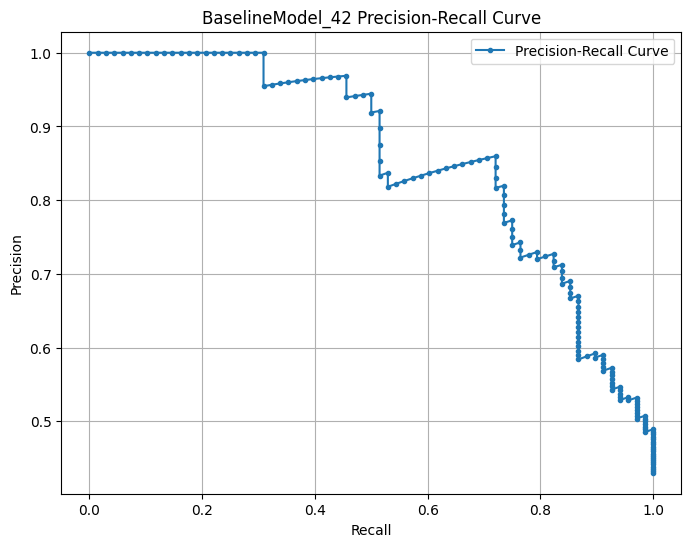

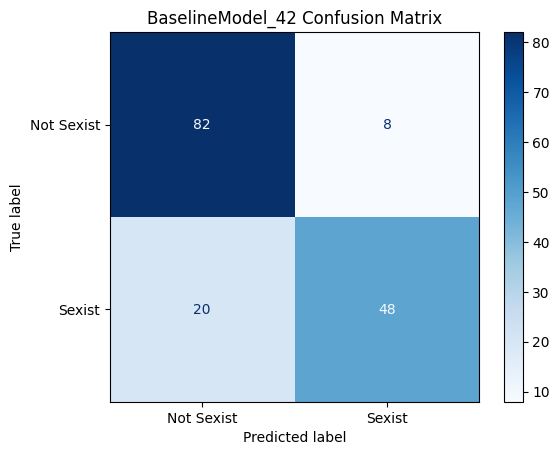



BaselineModel_42 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




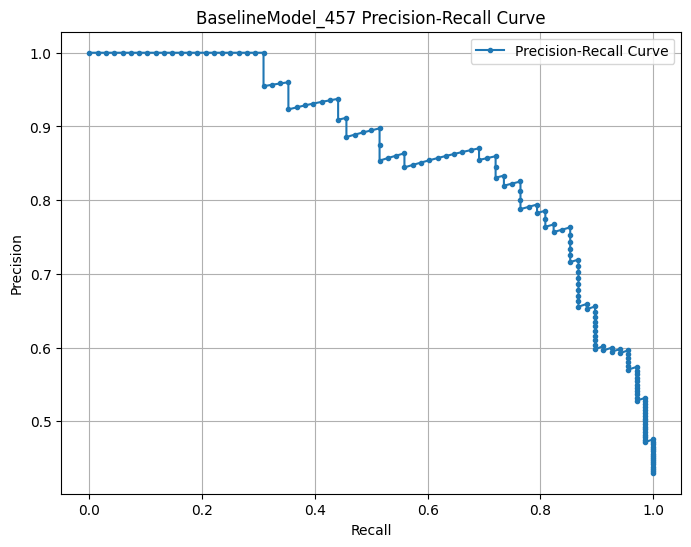

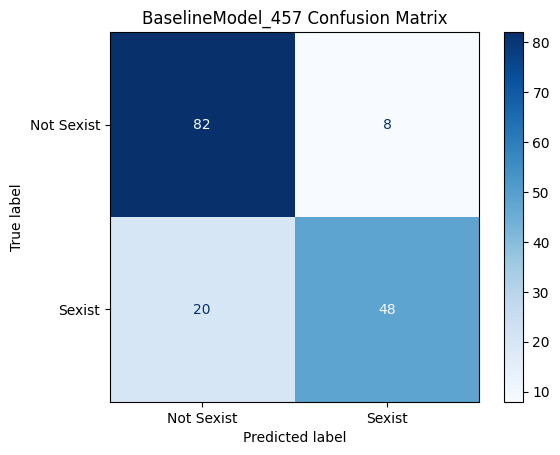



BaselineModel_457 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: collar between weareequal x    you already know it 🫵join our discord on how to join our exclusive giveaway
True Label: 0
Predicted Label: 1
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------




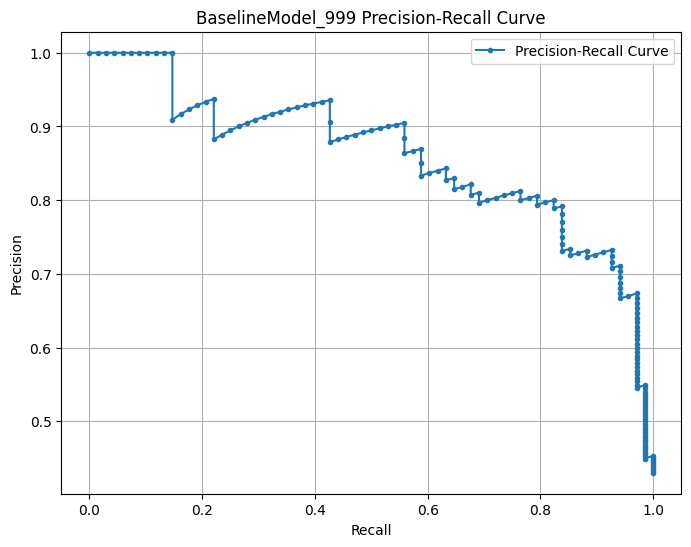

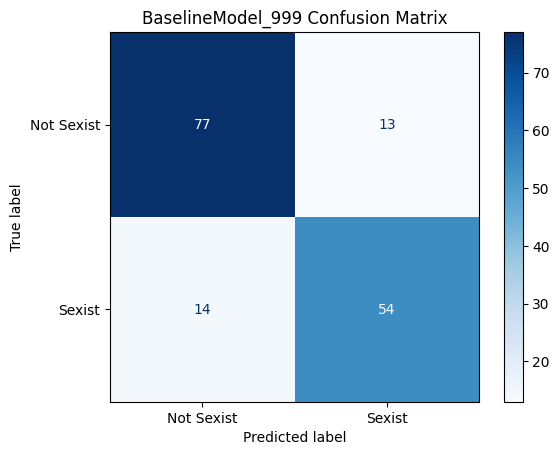



BaselineModel_999 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




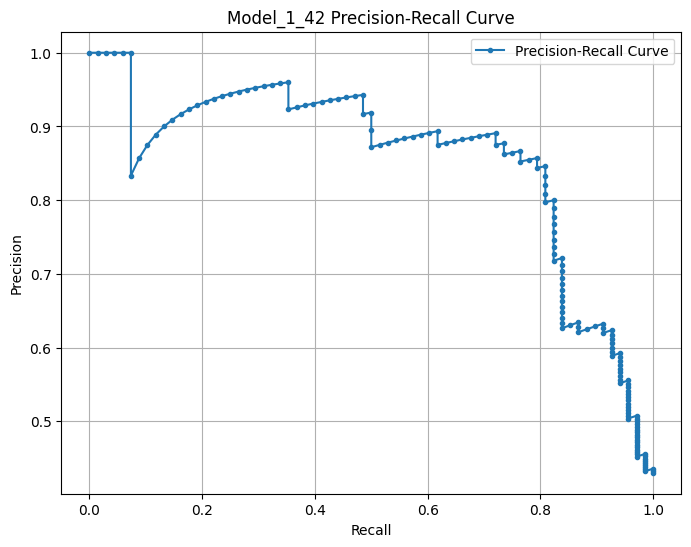

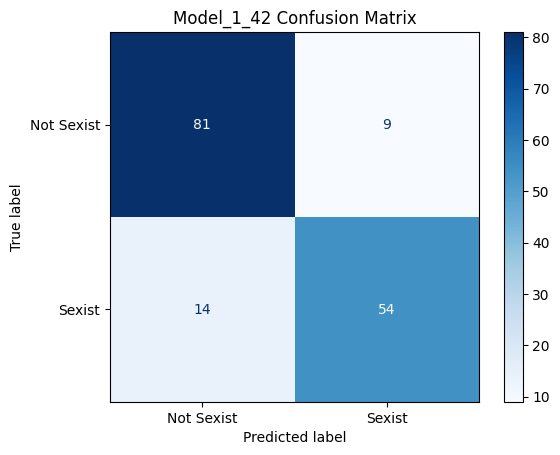



Model_1_42 Misclassified Samples:
Tweet: you should smile more love just pretend you re a tory open a food bank be only live through the bad   in live memory so its all a bit of a single cheer up darling it might never happen
True Label: 0
Predicted Label: 1
--------------------
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




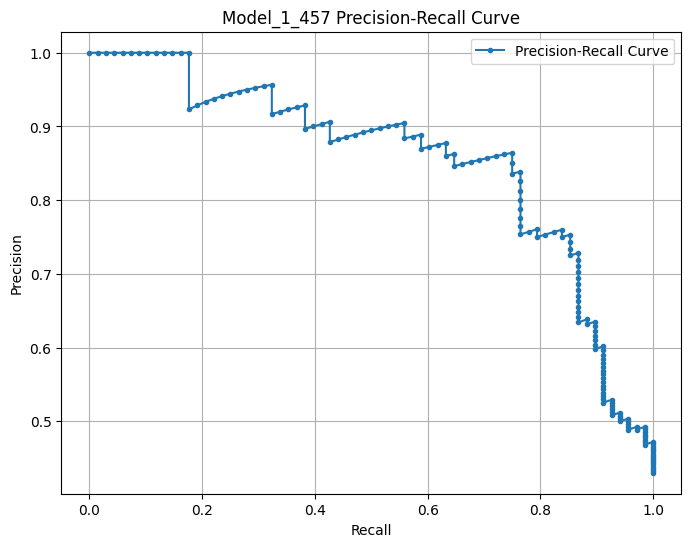

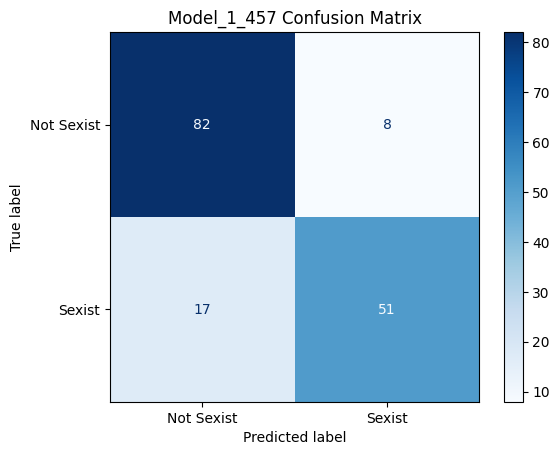



Model_1_457 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




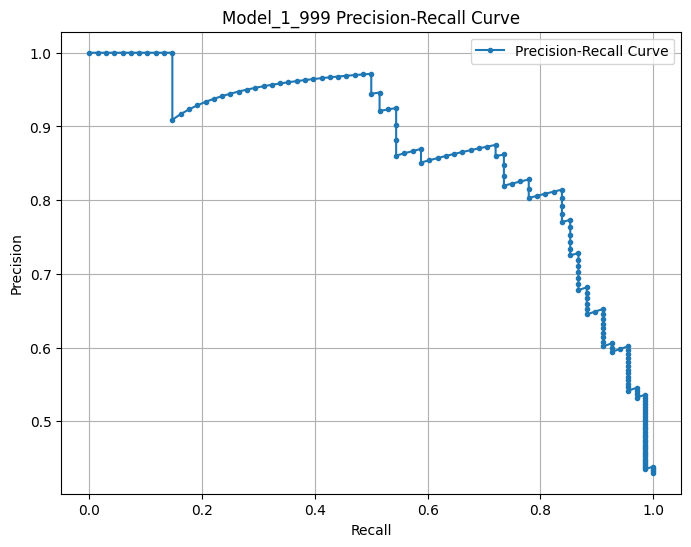

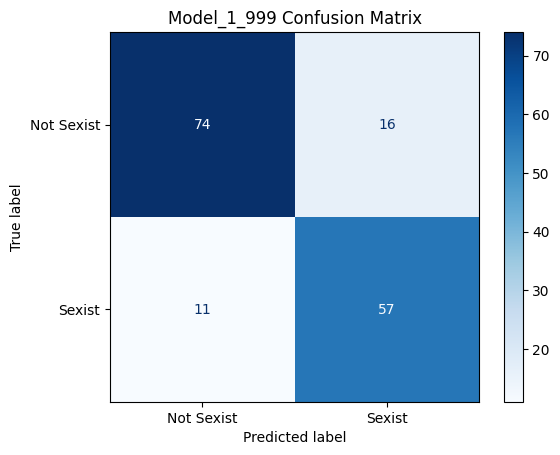



Model_1_999 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: collar between weareequal x    you already know it 🫵join our discord on how to join our exclusive giveaway
True Label: 0
Predicted Label: 1
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: wish all of you a very happy women day
True Label: 0
Predicted Label: 1
--------------------




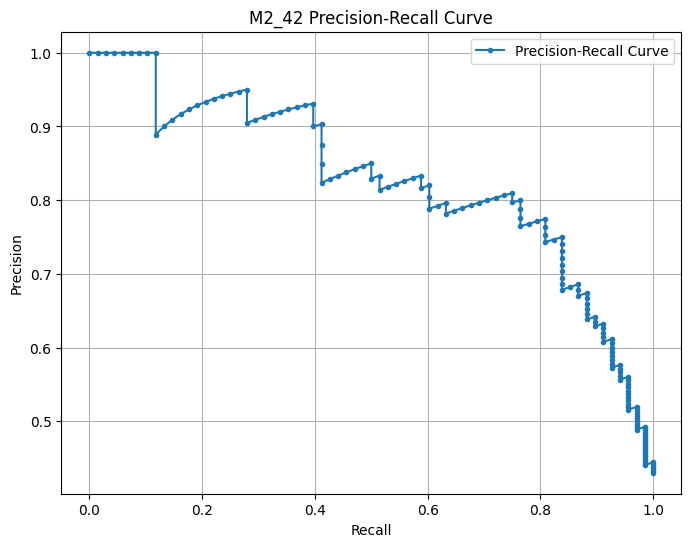

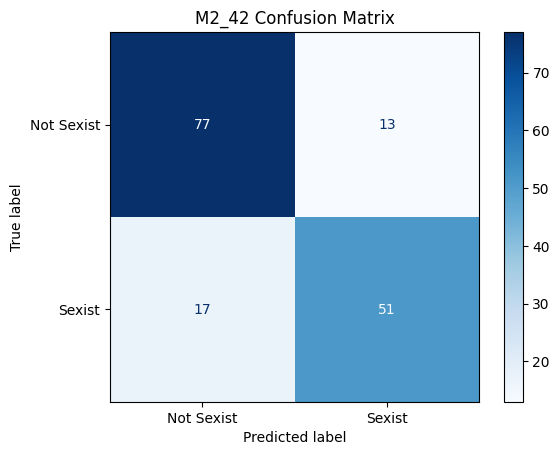



M2_42 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: be you look for the perfect gift to show your mom or wife how much you love and appreciate she this mother day   mention our purerelief ™ deluxe foot warm for optimal comfort holiness and relaxation click the link to learn more
True Label: 0
Predicted Label: 1
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------




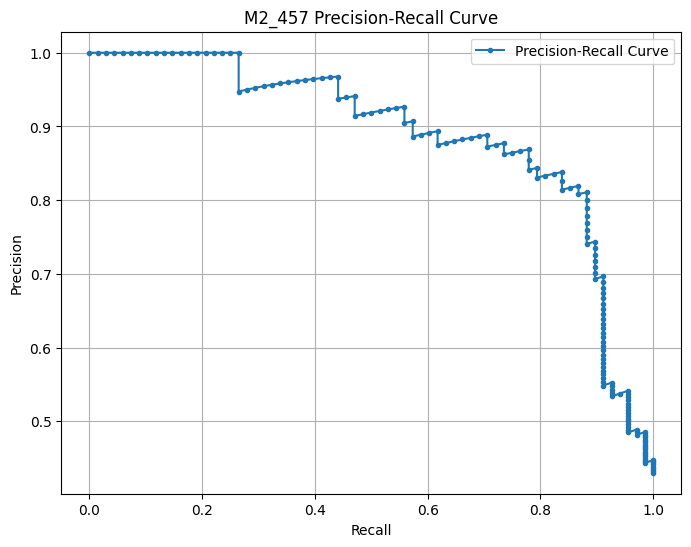

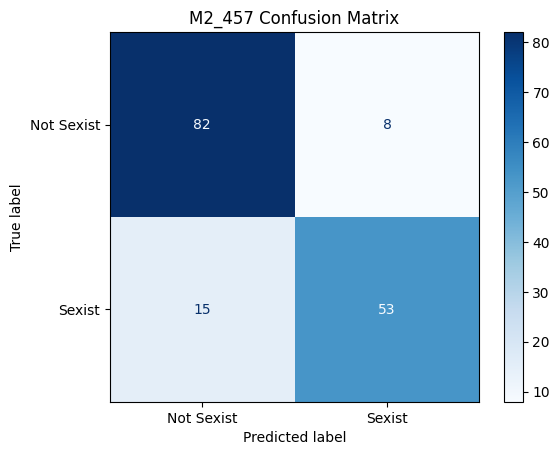



M2_457 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: raise taxis and control
True Label: 1
Predicted Label: 0
--------------------
Tweet: freedom convoy toronto wave provide flagtheyre live in the wrong decade
True Label: 1
Predicted Label: 0
--------------------
Tweet: nearly 10 of student will encounter sexual misconduct at school to5b9hs39w
True Label: 1
Predicted Label: 0
--------------------




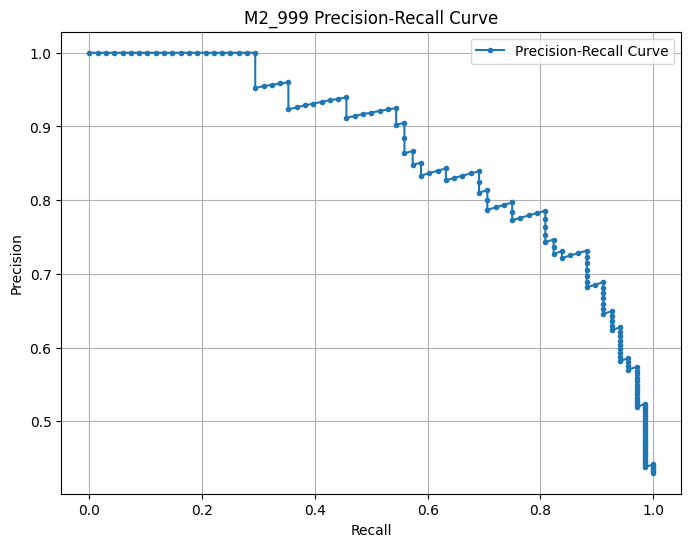

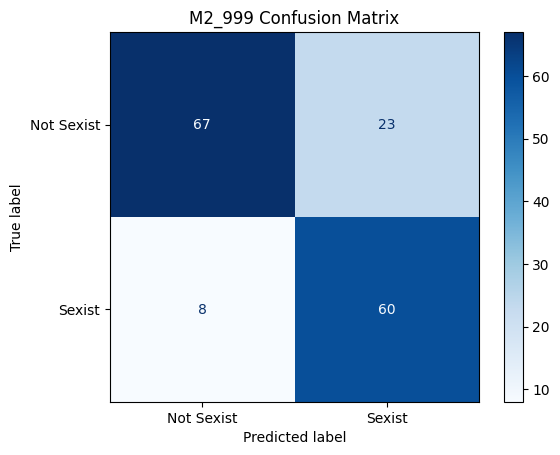



M2_999 Misclassified Samples:
Tweet: get twitter harass for pro choice
True Label: 1
Predicted Label: 0
--------------------
Tweet: I be hide in cat twitter mental health be really bad see a psychologist on friday I go to suicidal thought after be bully and harass by someone who be now no long a friend of mine or hobby
True Label: 0
Predicted Label: 1
--------------------
Tweet: I sincerely wish the we be this progressive on women right
True Label: 1
Predicted Label: 0
--------------------
Tweet: collar between weareequal x    you already know it 🫵join our discord on how to join our exclusive giveaway
True Label: 0
Predicted Label: 1
--------------------
Tweet: some courage jake daniels    hopefully you will open this su jet up to other footballer
True Label: 0
Predicted Label: 1
--------------------


In [80]:
validation_data = pd.DataFrame({'tweet': data_validation_cleaned['tweet'].tolist()})
true_labels = data_validation_cleaned['hard_label_task1'].tolist()

for m in metrics_summary:
  for seed in metrics_summary[m]:
    metrics = metrics_summary[m][seed]
    prediction_scores = metrics['val_prediction_scores']
    perform_error_analysis(generate_name(m, seed), data_validation_cleaned, true_labels= true_labels, predictions=np.array(prediction_scores))

# [Task 6 - 1.0 points] Transformers

In this section, you will use a transformer model specifically trained for hate speech detection, namely [Twitter-roBERTa-base for Hate Speech Detection](https://huggingface.co/cardiffnlp/twitter-roberta-base-hate).




### Relevant Material
- Tutorial 3

### Instructions
1. **Load the Tokenizer and Model**

2. **Preprocess the Dataset**:
   You will need to preprocess your dataset to prepare it for input into the model. Tokenize your text data using the appropriate tokenizer and ensure it is formatted correctly.

   **Note**: You have to use the plain text of the dataset and not the version that you tokenized before, as you need to tokenize the cleaned text obtained after the initial cleaning process.

3. **Train the Model**:
   Use the `Trainer` to train the model on your training data.

4. **Evaluate the Model on the Test Set** using F1-macro.

In [8]:
!pip install datasets
!pip install transformers

In [9]:
!pip install -U "huggingface_hub[cli]"


In [38]:
import numpy as np
import pandas as pd
from datasets import Dataset
from transformers import DataCollatorWithPadding
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, AutoTokenizer
from sklearn.metrics import f1_score, accuracy_score
import os

In [39]:
train_data = Dataset.from_pandas(data_training_cleaned)
validation_data = Dataset.from_pandas(data_validation_cleaned)
test_data = Dataset.from_pandas(data_test_cleaned)

In [40]:
train_data = train_data.rename_column('hard_label_task1', 'label')
validation_data = validation_data.rename_column('hard_label_task1', 'label')
test_data = test_data.rename_column('hard_label_task1', 'label')

In [41]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {"f1": f1, "accuracy": acc}


In [69]:
pretrained_models = {
    "cardiffnlp/twitter-roberta-base-hate": "cardiffnlp/twitter-roberta-base-hate",  
}
seeds = [144, 256, 42]

In [88]:

all_results = {}
best_models = {}

for model_name, tokenizer_name in pretrained_models.items():
    all_results[model_name] = {}
    for seed in seeds:
        print(f"\n{'='*50}")
        print(f"Starting training for {model_name} with seed {seed}")
        print(f"{'='*50}\n")

        print("1. Loading tokenizer...")
        tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        
        # Modified to use 'tweet' column
        def tokenize_function(examples):
            return tokenizer(examples['tweet'], truncation=True, padding='max_length', max_length=128)
        
        print("2. Preparing datasets...")
        tokenized_train = train_data.map(tokenize_function, batched=True)
        tokenized_val = validation_data.map(tokenize_function, batched=True)
        tokenized_test = test_data.map(tokenize_function, batched=True)
        data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
        print("3. Loading model...")
        model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=2,
            id2label={0: 'NO', 1: 'YES'},
            label2id={'NO': 0, 'YES': 1}
        )

        print("4. Setting up training arguments...")
        training_args = TrainingArguments(
            output_dir=f"./trained_model/{model_name.replace('/', '_')}_seed_{seed}",
            learning_rate=2e-05,
            per_device_train_batch_size=16,
            per_device_eval_batch_size=16,
            num_train_epochs=8,
            weight_decay=0.01,
            evaluation_strategy="epoch",
            save_strategy="epoch",
            lr_scheduler_type='linear',
            load_best_model_at_end=True,
            save_total_limit=1,
            metric_for_best_model="f1",
            greater_is_better=True,
            report_to="none",
            seed=seed,
            warmup_ratio=0.1,
            logging_steps=100,
            logging_first_step=True
        )

        early_stopping_callback = EarlyStoppingCallback(
            early_stopping_patience=2,
            early_stopping_threshold=0.01
        )

        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_train,
            eval_dataset=tokenized_val,
            tokenizer=tokenizer,
            data_collator=data_collator,
            compute_metrics=compute_metrics,
            callbacks=[early_stopping_callback]
        )

        print("6. Starting training...")
        try:
            train_output = trainer.train()
            print("Training completed successfully!")
            best_models[(model_name, seed)] = training_args.output_dir
            
            # Evaluate on test set
            print("7. Evaluating on test set...")
            test_results = trainer.evaluate(tokenized_val)
            all_results[model_name][seed] = test_results
            
            
        except Exception as e:
            print(f"Error during training: {str(e)}")
            continue


Starting training for cardiffnlp/twitter-roberta-base-hate with seed 144

1. Loading tokenizer...
2. Preparing datasets...


Map: 100%|██████████| 286/286 [00:00<00:00, 27794.22 examples/s]

3. Loading model...


4. Setting up training arguments...


/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/3224683835.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


6. Starting training...


  0%|          | 1/1440 [00:00<10:14,  2.34it/s]

{'loss': 0.6752, 'grad_norm': 12.345504760742188, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.01}


  7%|▋         | 100/1440 [00:43<09:42,  2.30it/s]

{'loss': 0.4714, 'grad_norm': 10.97596263885498, 'learning_rate': 1.388888888888889e-05, 'epoch': 0.56}


 12%|█▎        | 180/1440 [01:18<07:41,  2.73it/s]

{'eval_loss': 0.3447039723396301, 'eval_f1': 0.8642111724984654, 'eval_accuracy': 0.8670886075949367, 'eval_runtime': 1.2255, 'eval_samples_per_second': 128.923, 'eval_steps_per_second': 8.16, 'epoch': 1.0}


 14%|█▍        | 200/1440 [01:28<08:43,  2.37it/s]

{'loss': 0.425, 'grad_norm': 16.31563377380371, 'learning_rate': 1.9135802469135804e-05, 'epoch': 1.11}


 21%|██        | 300/1440 [02:11<07:58,  2.38it/s]

{'loss': 0.3409, 'grad_norm': 18.828065872192383, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.67}


 25%|██▌       | 360/1440 [02:37<06:26,  2.79it/s]

{'eval_loss': 0.3736947178840637, 'eval_f1': 0.8459843187115914, 'eval_accuracy': 0.8544303797468354, 'eval_runtime': 1.174, 'eval_samples_per_second': 134.587, 'eval_steps_per_second': 8.518, 'epoch': 2.0}


 28%|██▊       | 400/1440 [02:55<07:15,  2.39it/s]

{'loss': 0.2806, 'grad_norm': 13.984070777893066, 'learning_rate': 1.6049382716049385e-05, 'epoch': 2.22}


 35%|███▍      | 500/1440 [03:37<06:32,  2.40it/s]

{'loss': 0.1938, 'grad_norm': 10.956353187561035, 'learning_rate': 1.4506172839506174e-05, 'epoch': 2.78}


 38%|███▊      | 540/1440 [03:55<05:29,  2.73it/s]

{'eval_loss': 0.6178439259529114, 'eval_f1': 0.8291152930997188, 'eval_accuracy': 0.8417721518987342, 'eval_runtime': 1.1851, 'eval_samples_per_second': 133.322, 'eval_steps_per_second': 8.438, 'epoch': 3.0}


 38%|███▊      | 540/1440 [03:57<06:35,  2.27it/s]


{'train_runtime': 237.4696, 'train_samples_per_second': 96.686, 'train_steps_per_second': 6.064, 'train_loss': 0.3328779953497428, 'epoch': 3.0}
Training completed successfully!
7. Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.57it/s]



Starting training for cardiffnlp/twitter-roberta-base-hate with seed 256

1. Loading tokenizer...
2. Preparing datasets...


Map: 100%|██████████| 286/286 [00:00<00:00, 21611.17 examples/s]

3. Loading model...


4. Setting up training arguments...


/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/3224683835.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


6. Starting training...


  0%|          | 1/1440 [00:00<10:19,  2.32it/s]

{'loss': 0.8676, 'grad_norm': 18.197982788085938, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.01}


  7%|▋         | 100/1440 [00:41<09:19,  2.40it/s]

{'loss': 0.4826, 'grad_norm': 12.644590377807617, 'learning_rate': 1.388888888888889e-05, 'epoch': 0.56}


 12%|█▎        | 180/1440 [01:16<07:41,  2.73it/s]

{'eval_loss': 0.36971214413642883, 'eval_f1': 0.8562448304383788, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.2156, 'eval_samples_per_second': 129.974, 'eval_steps_per_second': 8.226, 'epoch': 1.0}


 14%|█▍        | 200/1440 [01:26<08:51,  2.33it/s]

{'loss': 0.413, 'grad_norm': 6.8625569343566895, 'learning_rate': 1.9135802469135804e-05, 'epoch': 1.11}


 21%|██        | 300/1440 [02:09<07:58,  2.38it/s]

{'loss': 0.3037, 'grad_norm': 24.788671493530273, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.67}


 25%|██▌       | 360/1440 [02:35<06:28,  2.78it/s]

{'eval_loss': 0.37116679549217224, 'eval_f1': 0.8531350346459354, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.1729, 'eval_samples_per_second': 134.703, 'eval_steps_per_second': 8.526, 'epoch': 2.0}


 28%|██▊       | 400/1440 [02:54<07:23,  2.35it/s]

{'loss': 0.2776, 'grad_norm': 11.7655611038208, 'learning_rate': 1.6049382716049385e-05, 'epoch': 2.22}


 35%|███▍      | 500/1440 [03:36<06:30,  2.41it/s]

{'loss': 0.2198, 'grad_norm': 36.57221221923828, 'learning_rate': 1.4506172839506174e-05, 'epoch': 2.78}


 38%|███▊      | 540/1440 [03:54<05:33,  2.70it/s]

{'eval_loss': 0.5354557037353516, 'eval_f1': 0.8522108843537415, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.1871, 'eval_samples_per_second': 133.097, 'eval_steps_per_second': 8.424, 'epoch': 3.0}


 38%|███▊      | 540/1440 [03:56<06:34,  2.28it/s]


{'train_runtime': 236.4412, 'train_samples_per_second': 97.107, 'train_steps_per_second': 6.09, 'train_loss': 0.32692265488483285, 'epoch': 3.0}
Training completed successfully!
7. Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.17it/s]



Starting training for cardiffnlp/twitter-roberta-base-hate with seed 42

1. Loading tokenizer...
2. Preparing datasets...


Map: 100%|██████████| 286/286 [00:00<00:00, 14717.94 examples/s]

3. Loading model...



huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/Users/ehsan/Desktop/NLP_assignment/nlp_assignment_1/.venv/lib/python3.11/site-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/3224683835.py:58: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


4. Setting up training arguments...
6. Starting training...


  0%|          | 1/1440 [00:00<10:20,  2.32it/s]

{'loss': 0.4605, 'grad_norm': 15.699357986450195, 'learning_rate': 1.3888888888888888e-07, 'epoch': 0.01}


  7%|▋         | 100/1440 [00:42<09:29,  2.35it/s]

{'loss': 0.4816, 'grad_norm': 10.504803657531738, 'learning_rate': 1.388888888888889e-05, 'epoch': 0.56}


 12%|█▎        | 180/1440 [01:17<07:37,  2.75it/s]

{'eval_loss': 0.3893112242221832, 'eval_f1': 0.8284043441938178, 'eval_accuracy': 0.8354430379746836, 'eval_runtime': 1.2307, 'eval_samples_per_second': 128.383, 'eval_steps_per_second': 8.126, 'epoch': 1.0}


 14%|█▍        | 200/1440 [01:27<08:37,  2.40it/s]

{'loss': 0.4224, 'grad_norm': 10.158513069152832, 'learning_rate': 1.9135802469135804e-05, 'epoch': 1.11}


 21%|██        | 300/1440 [02:09<07:51,  2.42it/s]

{'loss': 0.3353, 'grad_norm': 10.803266525268555, 'learning_rate': 1.7592592592592595e-05, 'epoch': 1.67}


 25%|██▌       | 360/1440 [02:36<06:38,  2.71it/s]

{'eval_loss': 0.33883005380630493, 'eval_f1': 0.8680033416875522, 'eval_accuracy': 0.8734177215189873, 'eval_runtime': 1.1851, 'eval_samples_per_second': 133.319, 'eval_steps_per_second': 8.438, 'epoch': 2.0}


 28%|██▊       | 400/1440 [02:55<07:22,  2.35it/s]

{'loss': 0.2864, 'grad_norm': 1.5604100227355957, 'learning_rate': 1.6049382716049385e-05, 'epoch': 2.22}


 35%|███▍      | 500/1440 [03:38<06:36,  2.37it/s]

{'loss': 0.2231, 'grad_norm': 14.002696990966797, 'learning_rate': 1.4506172839506174e-05, 'epoch': 2.78}


 38%|███▊      | 540/1440 [03:56<05:25,  2.76it/s]

{'eval_loss': 0.4200916886329651, 'eval_f1': 0.869313482216708, 'eval_accuracy': 0.8734177215189873, 'eval_runtime': 1.182, 'eval_samples_per_second': 133.674, 'eval_steps_per_second': 8.46, 'epoch': 3.0}


 42%|████▏     | 600/1440 [04:23<05:55,  2.37it/s]

{'loss': 0.1747, 'grad_norm': 13.311227798461914, 'learning_rate': 1.2962962962962964e-05, 'epoch': 3.33}


 49%|████▊     | 700/1440 [05:05<05:12,  2.37it/s]

{'loss': 0.1121, 'grad_norm': 4.350480556488037, 'learning_rate': 1.1419753086419753e-05, 'epoch': 3.89}


 50%|█████     | 720/1440 [05:14<04:20,  2.77it/s]

{'eval_loss': 0.7836160063743591, 'eval_f1': 0.8548036758563073, 'eval_accuracy': 0.8607594936708861, 'eval_runtime': 1.1665, 'eval_samples_per_second': 135.444, 'eval_steps_per_second': 8.572, 'epoch': 4.0}


 50%|█████     | 720/1440 [05:17<05:17,  2.27it/s]


{'train_runtime': 316.9387, 'train_samples_per_second': 72.443, 'train_steps_per_second': 4.543, 'train_loss': 0.2842117879125807, 'epoch': 4.0}
Training completed successfully!
7. Evaluating on test set...


100%|██████████| 10/10 [00:01<00:00,  9.63it/s]


In [89]:


print("\n--- Detailed Evaluation Results ---")
for model_name, seed_results in all_results.items():
    print(f"\nModel: {model_name}")
    f1_scores = []
    for seed, results in seed_results.items():
        f1 = results['eval_f1']
        f1_scores.append(f1)
        print(f"  Seed {seed}: F1 Score = {f1:.4f}")

    if f1_scores: # Check if there are any successful evaluations
        avg_f1 = np.mean(f1_scores)
        std_f1 = np.std(f1_scores)
        print(f"  Average F1 Score (across seeds): {avg_f1:.4f}")
        print(f"  Standard Deviation of F1 Scores: {std_f1:.4f}")
        # print("  Analysis:")
        # if std_f1 > 0.01:
        #     print("    Significant variation in performance across different seeds.")
        # else:
        #     print("    Consistent performance across different seeds, suggesting a more robust training process for this model.")

    else:
        print("  No successful evaluations for this model.")

print("\n--- Paths to the Best Models ---")
for (model_name, seed), path in best_models.items():
    print(f"Best model for {model_name} with seed {seed}: {path}")


--- Detailed Evaluation Results ---

Model: cardiffnlp/twitter-roberta-base-hate
  Seed 144: F1 Score = 0.8642
  Seed 256: F1 Score = 0.8562
  Seed 42: F1 Score = 0.8693
  Average F1 Score (across seeds): 0.8633
  Standard Deviation of F1 Scores: 0.0054

--- Paths to the Best Models ---
Best model for cardiffnlp/twitter-roberta-base-hate with seed 144: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_144
Best model for cardiffnlp/twitter-roberta-base-hate with seed 256: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_256
Best model for cardiffnlp/twitter-roberta-base-hate with seed 42: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_42


Processing model: cardiffnlp_twitter-roberta-base-hate_seed_42 using checkpoint: ./trained_model/cardiffnlp_twitter-roberta-base-hate_seed_42/checkpoint-540


/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/4223451030.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
100%|██████████| 10/10 [00:01<00:00,  9.59it/s]


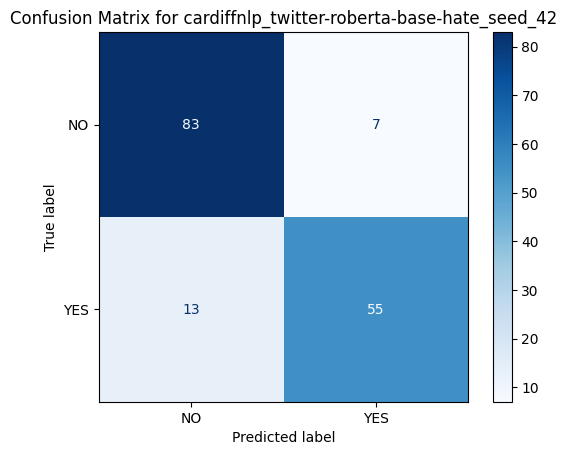

/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/4223451030.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



False Positive rows for cardiffnlp_twitter-roberta-base-hate_seed_42:
                                                 tweet  label  predicted_label
13   yo radical republicansamp member of the patria...      0                1
22              wish all of you a very happy women day      0                1
27       this world would not last a day without woman      0                1
32   gynocentrism and androcentrism if you want to ...      0                1
53   bitch a maker mark bottle you have see a docto...      0                1
111  I mean the pitcher netflix be ass and not beca...      0                1
156  this be your reminder that you can be child wo...      0                1

False Negative rows for cardiffnlp_twitter-roberta-base-hate_seed_42:
                                                 tweet  label  predicted_label
7                    get twitter harass for pro choice      1                0
24                             raise taxis and control      1       

100%|██████████| 10/10 [00:01<00:00,  9.68it/s]


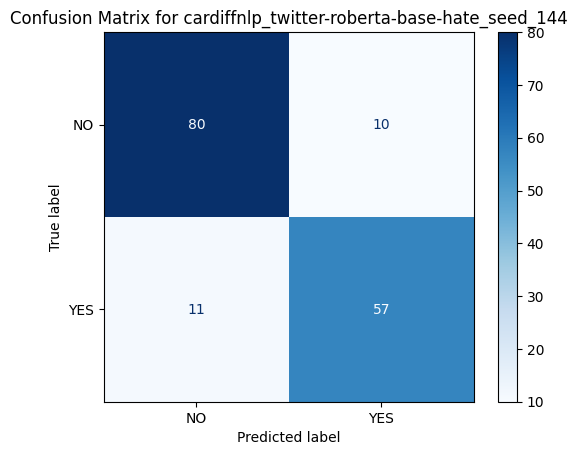

/var/folders/x6/t819xn051hvgc3lldbwgshrr0000gn/T/ipykernel_94472/4223451030.py:39: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(



False Positive rows for cardiffnlp_twitter-roberta-base-hate_seed_144:
                                                 tweet  label  predicted_label
6    show off the man spend his money help the econ...      0                1
13   yo radical republicansamp member of the patria...      0                1
22              wish all of you a very happy women day      0                1
27       this world would not last a day without woman      0                1
33   an androgynous mind be not a male mind it be a...      0                1
53   bitch a maker mark bottle you have see a docto...      0                1
66   also this may make people call I sexist but I ...      0                1
96   the reason she say its mindless be because it ...      0                1
111  I mean the pitcher netflix be ass and not beca...      0                1
156  this be your reminder that you can be child wo...      0                1

False Negative rows for cardiffnlp_twitter-roberta-base-ha

100%|██████████| 10/10 [00:01<00:00,  9.72it/s]


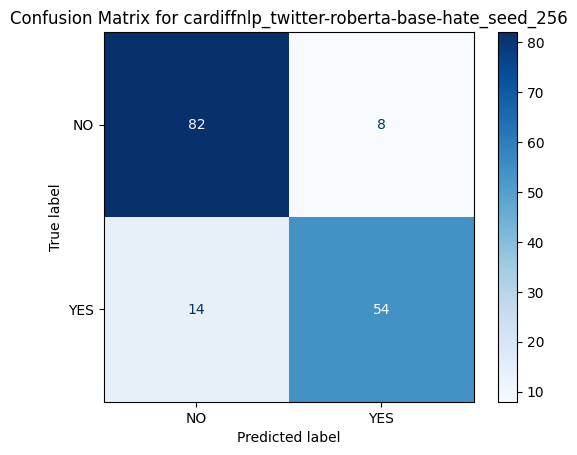


False Positive rows for cardiffnlp_twitter-roberta-base-hate_seed_256:
                                                 tweet  label  predicted_label
6    show off the man spend his money help the econ...      0                1
13   yo radical republicansamp member of the patria...      0                1
22              wish all of you a very happy women day      0                1
27       this world would not last a day without woman      0                1
53   bitch a maker mark bottle you have see a docto...      0                1
96   the reason she say its mindless be because it ...      0                1
111  I mean the pitcher netflix be ass and not beca...      0                1
156  this be your reminder that you can be child wo...      0                1

False Negative rows for cardiffnlp_twitter-roberta-base-hate_seed_256:
                                                 tweet  label  predicted_label
7                    get twitter harass for pro choice      1     

In [95]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Define the base directory and model names
base_dir = './trained_model'
models = [
    "cardiffnlp_twitter-roberta-base-hate_seed_42",
    "cardiffnlp_twitter-roberta-base-hate_seed_144",
    "cardiffnlp_twitter-roberta-base-hate_seed_256"
]

# Initialize the final DataFrame
df_columns = ["tweet", "label"] + [f"{model}_pred" for model in models] 
final_df = pd.DataFrame(columns=df_columns)

# Function to find the latest checkpoint in a directory
def find_latest_checkpoint(model_path):
    checkpoints = [d for d in os.listdir(model_path) if d.startswith("checkpoint-")]
    latest_checkpoint = sorted(checkpoints, key=lambda x: int(x.split("-")[1]))[-1]
    return os.path.join(model_path, latest_checkpoint)

# Iterate over models and checkpoints
predictions_dict = {}
for model_name in models:
    model_path = os.path.join(base_dir, model_name)
    checkpoint_path = find_latest_checkpoint(model_path)
    print(f"Processing model: {model_name} using checkpoint: {checkpoint_path}")

    # Load tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)
    model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path, trust_remote_code=True)

    # Initialize Trainer
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    trainer = Trainer(
        model=model,
        args=TrainingArguments(
            output_dir=checkpoint_path,
            per_device_eval_batch_size=16,
            report_to="none"
        ),
        tokenizer=tokenizer,
        data_collator=data_collator
    )

    # Generate predictions
    predictions = trainer.predict(tokenized_val)
    preds = np.argmax(predictions.predictions, axis=-1)
    predictions_dict[model_name] = preds

    # Compute confusion matrix
    cm = confusion_matrix(tokenized_val['label'], preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NO', 'YES'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()

    # Print False Positives and False Negatives
    tokenized_val_df = pd.DataFrame({
        "tweet": tokenized_val["tweet"],
        "label": tokenized_val["label"]
    })

    # Print False Positives and False Negatives
    fp_rows = tokenized_val_df[(tokenized_val_df["label"] == 0) & (preds == 1)]
    fn_rows = tokenized_val_df[(tokenized_val_df["label"] == 1) & (preds == 0)]

    print(f"\nFalse Positive rows for {model_name}:")
    print(fp_rows.assign(predicted_label=1)[["tweet", "label", "predicted_label"]])

    print(f"\nFalse Negative rows for {model_name}:")
    print(fn_rows.assign(predicted_label=0)[["tweet", "label", "predicted_label"]])

# Populate the DataFrame
final_df["tweet"] = tokenized_val["tweet"]
final_df["label"] = tokenized_val["label"]
for model_name in models:
    final_df[f"{model_name}_pred"] = predictions_dict[model_name]

# Compute major voting
preds_array = np.array([predictions_dict[model] for model in models])
major_vote = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=preds_array)
final_df["major_vote_cardiffnlp_twitter-roberta-base-hate"] = major_vote

# Save the final DataFrame
output_path = os.path.join(base_dir, "final_predictions_1.pkl")
final_df.to_pickle(output_path)
print(f"Final DataFrame saved at {output_path}")


In [96]:
print(final_df.head())

                                               tweet  label  \
0  you should smile more love just pretend you re...      0   
1  she be right but the push be all in the opposi...      1   
2  some man move my suitcase in the overhead lugg...      1   
3  lol gamergate the go to boogieman maybe if the...      0   
4  to I this have the same negativity as gamergat...      0   

   cardiffnlp_twitter-roberta-base-hate_seed_42_pred  \
0                                                  0   
1                                                  1   
2                                                  1   
3                                                  0   
4                                                  0   

   cardiffnlp_twitter-roberta-base-hate_seed_144_pred  \
0                                                  0    
1                                                  1    
2                                                  1    
3                                                  0    

# [Task 7 - 0.5 points] Error Analysis

### Instructions

After evaluating the model, perform a brief error analysis:

 - Review the results and identify common errors.

 - Summarize your findings regarding the errors and their impact on performance (e.g. but not limited to Out-of-Vocabulary (OOV) words, data imbalance, and performance differences between the custom model and the transformer...)
 - Suggest possible solutions to address the identified errors.



# [Task 8 - 0.5 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.


# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Execution Order

You are **free** to address tasks in any order (if multiple orderings are available).

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).
However, you are **free** to play with their hyper-parameters.


### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Robust Evaluation

Each model is trained with at least 3 random seeds.

Task 4 requires you to compute the average performance over the 3 seeds and its corresponding standard deviation.

### Model Selection for Analysis

To carry out the error analysis you are **free** to either

* Pick examples or perform comparisons with an individual seed run model (e.g., Baseline seed 1337)
* Perform ensembling via, for instance, majority voting to obtain a single model.

### Error Analysis

Some topics for discussion include:
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Bonus Points
Bonus points are arbitrarily assigned based on significant contributions such as:
- Outstanding error analysis
- Masterclass code organization
- Suitable extensions
Note that bonus points are only assigned if all task points are attributed (i.e., 6/6).

**Possible Extensions/Explorations for Bonus Points:**
- **Try other preprocessing strategies**: e.g., but not limited to, explore techniques tailored specifically for tweets or  methods that are common in social media text.
- **Experiment with other custom architectures or models from HuggingFace**
- **Explore Spanish tweets**: e.g., but not limited to, leverage multilingual models to process Spanish tweets and assess their performance compared to monolingual models.







# The End